In [8]:
# 从数据库中读取数据包
from pyspark.sql import SparkSession
import os
from pytoolkit import TDWSQLProvider
import pandas

In [9]:
# 连接spark,这个只允许运行一次，再次运行需要重启内核
os.environ['GROUP_ID'] = 'g_wxg_wxt_product_analytics_intern'
os.environ['GAIA_ID'] = '5729'
session = SparkSession.builder.config('spark.driver.maxResultSize','14g').config('spark.driver.memory', '14g').config('spark.executor.cores', 4).config('spark.executor.memory', '14g').config('spark.yarn.archive','hdfs://qy-ieg-4-v2/data/SPARK/cachefile/3_12_2.4.6_hadoop3/spark-jars_old_notauth.zip').getOrCreate()
# session = SparkSession.builder.config('spark.driver.memory', '8g').config('spark.executor.cores', 4).config('spark.executor.memory', '8g').getOrCreate()

In [ ]:
# 若数据量小，可以直接读取
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_weixin_analytics_intern')
df=provider.table('tmp_dws_app_bilateral_expt_11010219_finder_intern_uin_i').toPandas()

In [14]:
# 若数据量较大，分不同的sql读取
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_weixin_analytics_intern')
tbl=provider.table('tmp_dws_app_bilateral_expt_11010219_finder_intern_uin_i')
tbl.createOrReplaceTempView('tbl')
df=session.sql('select * from tbl limit 100').toPandas()

In [15]:
df

,ds,groupid,first_hit_ds,is_active_today,stay_cnt,like_svr_cnt,follow_svr_cnt,forward_cnt,cold_start_stay_cnt,stay_time,anonymous
0,20220328,253814,20220402,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,cf5d25623e771b880a3262f43f18dbe5
1,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,893622d1e54504eeb0a3fec7e1d52e62
2,20220328,253814,20220331,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,a4806c2a63f1c233a47ca06528ab4f24
3,20220328,253814,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,ba3310215cb7e1fa4f0d9e575475e4fd
4,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,a523b49b164aa930e07041bfbb910096
...,...,...,...,...,...,...,...,...,...,...,...
95,20220328,253816,20220325,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,f6a403c3748e66da428bae43bdb7e299
96,20220328,253815,20220326,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,fd55dd4de9d2ad49f8dd28a3f5c8d4e3
97,20220328,253814,20220327,7.929746,2.959817,3.259428,8.343132,2.097061,7.390883,0.700326,4726e849106c124140343cbb8c828687
98,20220328,253814,20220325,17.209022,515.173740,19.006659,8.343132,2.097061,7.390883,63553.099801,93c5ff2c2cacf94517287eb238939b49


In [3]:
#数据分析包
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# 
from metric_funcs import Ttest, Metric
from frt_pvalue import sharp_null_hypothesis_pvalue

In [4]:
df.head(5)

,ds,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,anonymous
0,20220321,251301,20220327,3.007821,5.848722,7.982649,8.408615,97a36a811d9caddf6f0fd01960acccc0
1,20220321,251300,20220322,3.007821,5.848722,7.982649,8.408615,13d4522f483d0267a39598a400525063
2,20220321,251300,20220321,3.007821,5.848722,7.982649,8.408615,0ff897fc42586de68939ad2f0e81049a
3,20220321,251299,20220328,3.007821,5.848722,7.982649,8.408615,b796ffd34875119248a427200171c887
4,20220321,251300,20220323,3.007821,5.848722,7.982649,8.408615,c3f08fba49abba83f90aef5265334bd8


# 数据分析

## 1. initial data exploration

In [5]:
df.head(5)

,ds,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,anonymous
0,20220321,251301,20220327,3.007821,5.848722,7.982649,8.408615,97a36a811d9caddf6f0fd01960acccc0
1,20220321,251300,20220322,3.007821,5.848722,7.982649,8.408615,13d4522f483d0267a39598a400525063
2,20220321,251300,20220321,3.007821,5.848722,7.982649,8.408615,0ff897fc42586de68939ad2f0e81049a
3,20220321,251299,20220328,3.007821,5.848722,7.982649,8.408615,b796ffd34875119248a427200171c887
4,20220321,251300,20220323,3.007821,5.848722,7.982649,8.408615,c3f08fba49abba83f90aef5265334bd8


In [6]:
df.dtypes

ds                    int64
groupid               int64
first_hit_ds          int64
feed_cnt_hot_100    float64
feed_cnt_hot_5k     float64
feed_cnt            float64
post_cnt            float64
anonymous            object
dtype: object

numerical variable：
feed_cnt_hot_100: 24小时内曝光达到100的feed
feed_cnt_hot_5k: 24小时内曝光达到5000的feed
feed_cnt: 当天冷启的feed数
post_cnt: 当天发表的全部视频数
    
catgorical variable:
anonymous: user nuique id
ds: date
first_hit_ds: 首次命中的日期
group_id: 是哪个实验组

In [13]:
numerical_col=["post_cnt"]
categorical_col=["anonymous","ds","first_hit_ds","groupid"]

## 2.Univariate Analysis

### 2.1 orginal data

In [14]:
# Univariate statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

output=unistats(df)
output.to_excel("f_univariate_statistics.xls")

In [15]:
output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,5374499,0,413423,object,False,-,-,-,-,-,-,-,-,-
ds,5374499,0,13,int64,True,-,-,-,-,-,-,-,-,-
first_hit_ds,5374499,0,13,int64,True,-,-,-,-,-,-,-,-,-
groupid,5374499,0,3,int64,True,-,-,-,-,-,-,-,-,-
post_cnt,5374499,0,124,float64,True,8.520604,8.408615,8.408615,8.408615,8.408615,175.614761,0.471147,60.188352,12213.934016


### 2.2 restore real data

#### restore numerical data

In [16]:
# copy data
new_df=df

In [17]:
# (1) -min (suppose min= 0)
for col in numerical_col:
    print(col,np.sort(df[col].unique())[0:2])

post_cnt [8.40861517 8.84404784]


In [18]:
for col in numerical_col:
    B= np.sort(df[col].unique())[0]
    A= np.sort(df[col].unique())[1]-np.sort(df[col].unique())[0]
    print(col,B,A)
    new_df[col]=(df[col]-B)/A
    print(col,np.sort(new_df[col].unique())[0:2])

post_cnt 8.408615171556876 0.4354326710191927
post_cnt [0. 1.]


In [19]:
np.round(new_df.describe(),3)

,ds,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt
count,5.374499e+06,5374499.000,5.374499e+06,5374499.000,5374499.000,5374499.000,5374499.000
mean,2.022034e+07,251300.001,2.022033e+07,3.008,5.849,7.983,0.257
std,2.739600e+01,0.816,2.087600e+01,0.000,0.000,0.000,1.082
min,2.022032e+07,251299.000,2.022032e+07,3.008,5.849,7.983,0.000
25%,2.022032e+07,251299.000,2.022032e+07,3.008,5.849,7.983,0.000
50%,2.022033e+07,251300.000,2.022032e+07,3.008,5.849,7.983,0.000
75%,2.022033e+07,251301.000,2.022033e+07,3.008,5.849,7.983,0.000
max,2.022040e+07,251301.000,2.022040e+07,3.008,5.849,7.983,384.000


In [20]:
# check new data
for col in numerical_col:
    print(np.sort(new_df[col].unique())[0:15])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


#### restore categorical data

### 2.3 cleaning data

In [21]:
# check first_hit_ds
new_df["in_experiment"]=np.where(pd.to_numeric(new_df["ds"])>new_df["first_hit_ds"],1,0)

In [22]:
new_df["in_experiment"].value_counts()

1    3063096
0    2311403
Name: in_experiment, dtype: int64

In [23]:
numerical_col=["post_cnt"]
categorical_col=["anonymous","ds","first_hit_ds","groupid","in_experiment"]

### 2.4 univariate analysis

#### statistics analysis

In [24]:
# statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

new_df_output=unistats(new_df)
new_df_output.to_excel("f_new_univariate_statistics.xls")

In [25]:
new_df_output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,5374499,0,413423,object,False,-,-,-,-,-,-,-,-,-
ds,5374499,0,13,int64,True,-,-,-,-,-,-,-,-,-
first_hit_ds,5374499,0,13,int64,True,-,-,-,-,-,-,-,-,-
groupid,5374499,0,3,int64,True,-,-,-,-,-,-,-,-,-
in_experiment,5374499,0,2,int64,True,-,-,-,-,-,-,-,-,-
post_cnt,5374499,0,124,float64,True,0.25719,0.0,0.0,0.0,0.0,384.0,1.082021,60.188352,12213.934016


In [26]:
# categorical--statistics
for col in categorical_col[1:len(categorical_col)]:
    print(new_df[col].value_counts())

20220321    413423
20220323    413423
20220322    413423
20220325    413423
20220324    413423
20220327    413423
20220326    413423
20220329    413423
20220328    413423
20220331    413423
20220330    413423
20220401    413423
20220402    413423
Name: ds, dtype: int64
20220321    1096498
20220322     471484
20220326     432341
20220323     426816
20220324     414596
20220327     390949
20220325     387036
20220328     342043
20220401     338975
20220330     333307
20220329     328315
20220331     322842
20220402      89297
Name: first_hit_ds, dtype: int64
251301    1793870
251300    1793233
251299    1787396
Name: groupid, dtype: int64
1    3063096
0    2311403
Name: in_experiment, dtype: int64


#### visualization analysis

array([[<AxesSubplot:title={'center':'ds'}>,
        <AxesSubplot:title={'center':'groupid'}>,
        <AxesSubplot:title={'center':'first_hit_ds'}>],
       [<AxesSubplot:title={'center':'feed_cnt_hot_100'}>,
        <AxesSubplot:title={'center':'feed_cnt_hot_5k'}>,
        <AxesSubplot:title={'center':'feed_cnt'}>],
       [<AxesSubplot:title={'center':'post_cnt'}>,
        <AxesSubplot:title={'center':'in_experiment'}>, <AxesSubplot:>]],
      dtype=object)

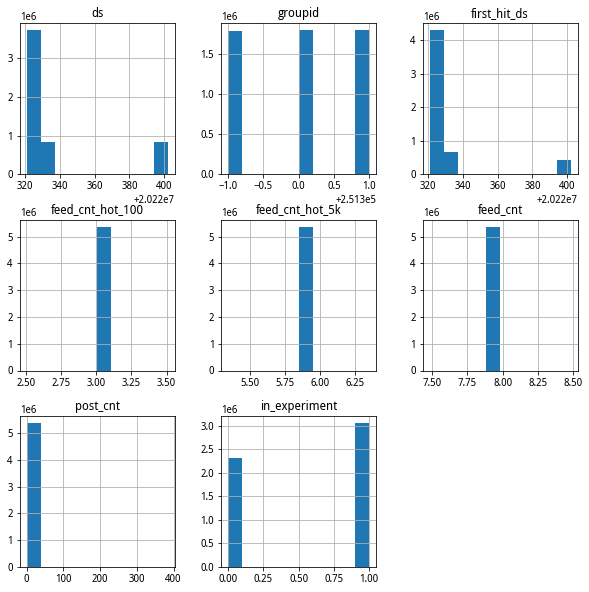

In [27]:
# # Univariate visualization(numerical variable)--histgram
new_df.hist(figsize=(10,10))

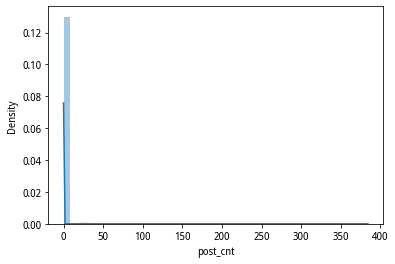

In [28]:
# # Univariate visualization(categorical variable)--brachart
for col in numerical_col:
    sns.distplot(new_df[col])
    plt.show()

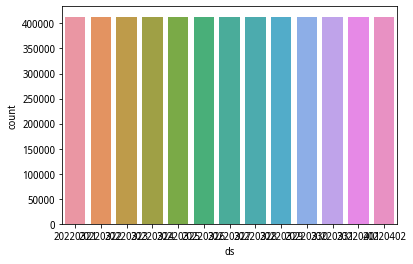

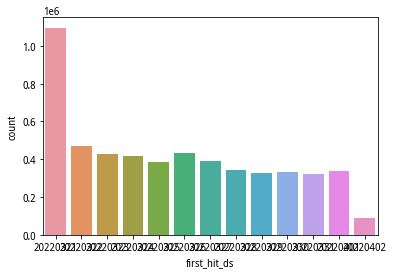

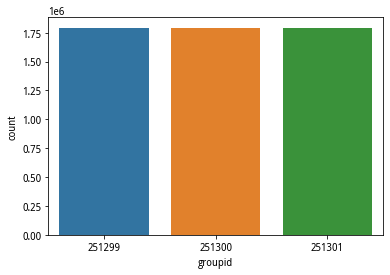

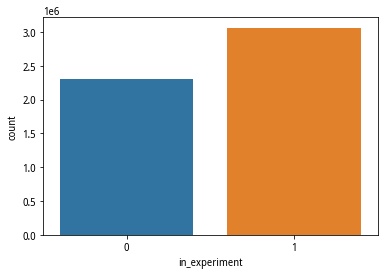

In [29]:
# # Univariate visualization(categorical variable)--brachart
for col in categorical_col[1:len(categorical_col)]:
    sns.countplot(new_df[col])
    plt.show()

conlusion:
1. panel data: individul: 413423, 13 period(20220321-0402) , total data: 5374499
2. first_hit_sd: 13 different joining days,(20220321--0402)-- filter out 2311403
3. groupid: 251299 is control，251300 and 251301 is treatment
4. for numerical variable: they all highly right skew, a lot of zeros.

## 3.Bivarite Analysis

In [30]:
# filter out 没参与实验的user
new_new_df= new_df

In [31]:
new_new_df.drop(new_new_df[new_new_df["in_experiment"]==0].index,inplace=True)

In [32]:
# statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

new_new_df_output=unistats(new_new_df)
new_new_df_output.to_excel("f_new_new_univariate_statistics.xls")

In [33]:
new_new_df_output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,3063096,0,406554,object,False,-,-,-,-,-,-,-,-,-
ds,3063096,0,12,int64,True,-,-,-,-,-,-,-,-,-
first_hit_ds,3063096,0,12,int64,True,-,-,-,-,-,-,-,-,-
groupid,3063096,0,3,int64,True,-,-,-,-,-,-,-,-,-
in_experiment,3063096,0,1,int64,True,-,-,-,-,-,-,-,-,-
post_cnt,3063096,0,114,float64,True,0.253262,0.0,0.0,0.0,0.0,339.0,1.16306,47.14182,6607.630161


#### (1) numerical- numerical

##### correlation 

In [34]:
# (1) Numerical/Numerical
# numercial=4个
np.round(new_new_df[numerical_col].corr(),3)

,post_cnt
post_cnt,1.0


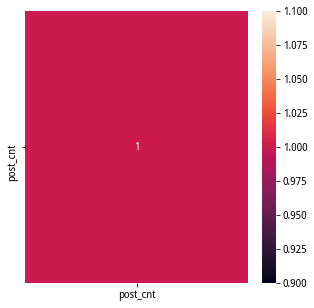

In [35]:
# 画correlation heat map图
plt.figure(figsize=(5,5))
sns.heatmap(np.round(new_new_df[numerical_col].corr(),3),annot=True)
plt.show()

##### visualization--scatterplot

In [ ]:
sns.regplot(new_new_df["post_cnt"],new_new_df["feed_cnt"])

KeyboardInterrupt: 

In [ ]:
sns.regplot(new_new_df["post_cnt"],new_new_df["feed_cnt_hot_100"])

<AxesSubplot:xlabel='post_cnt', ylabel='feed_cnt_hot_5k'>

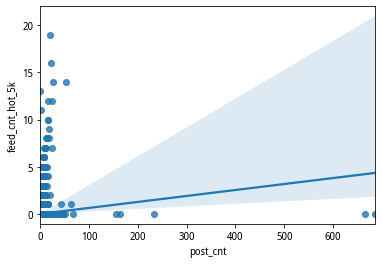

In [29]:
sns.regplot(new_new_df["post_cnt"],new_new_df["feed_cnt_hot_5k"])

<AxesSubplot:xlabel='feed_cnt', ylabel='feed_cnt_hot_100'>

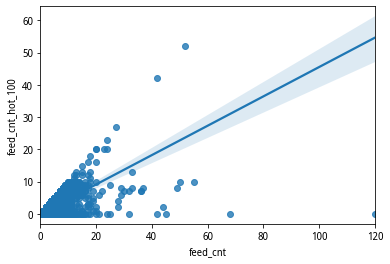

In [30]:
sns.regplot(new_new_df["feed_cnt"],new_new_df["feed_cnt_hot_100"])

<AxesSubplot:xlabel='feed_cnt', ylabel='feed_cnt_hot_5k'>

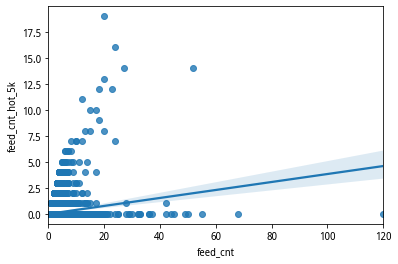

In [31]:
sns.regplot(new_new_df["feed_cnt"],new_new_df["feed_cnt_hot_5k"])

<AxesSubplot:xlabel='feed_cnt_hot_100', ylabel='feed_cnt_hot_5k'>

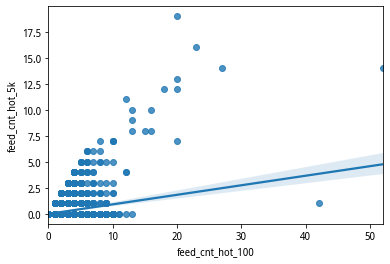

In [32]:
sns.regplot(new_new_df["feed_cnt_hot_100"],new_new_df["feed_cnt_hot_5k"])

In [ ]:
# (2)Categorical/Numerical
# categorical = 看下日期和分组，分别的对不同nmuerical的影响
# # statistics--计算下ATE和p值
# 按照日期(一共有三天)
np.round(new_new_df.groupby(new_new_df["ds"]).mean(),3)

In [35]:
# 按照分组
np.round(new_new_df.groupby(new_new_df["groupid"]).mean(),3)

,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,in_experiment
groupid,,,,,,
308998,2.022071e+07,0.064,0.003,0.113,0.120,1.0
308999,2.022071e+07,0.067,0.002,0.113,0.118,1.0


In [36]:
# 按照分组
new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"]]).mean()

first_hit_ds  feed_cnt_hot_100  feed_cnt_hot_5k  feed_cnt  \
groupid ds                                                                    
308998  20220717  2.022071e+07          0.065350         0.002720  0.115875   
        20220718  2.022071e+07          0.063271         0.002699  0.110596   
308999  20220717  2.022071e+07          0.067687         0.002345  0.118163   
        20220718  2.022071e+07          0.065611         0.002208  0.108836   

                  post_cnt  in_experiment  
groupid ds                                 
308998  20220717  0.121641            1.0  
        20220718  0.118284            1.0  
308999  20220717  0.125159            1.0  
        20220718  0.111913            1.0

In [38]:
# 按照分组
treatment_effect= np.round(new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"]]).mean(),3)
treatment_effect.to_excel("f_treatment_effect.xls")

In [39]:
treatment_effect

first_hit_ds  feed_cnt_hot_100  feed_cnt_hot_5k  feed_cnt  \
groupid ds                                                                    
308998  20220717  2.022071e+07             0.065            0.003     0.116   
        20220718  2.022071e+07             0.063            0.003     0.111   
308999  20220717  2.022071e+07             0.068            0.002     0.118   
        20220718  2.022071e+07             0.066            0.002     0.109   

                  post_cnt  in_experiment  
groupid ds                                 
308998  20220717     0.122            1.0  
        20220718     0.118            1.0  
308999  20220717     0.125            1.0  
        20220718     0.112            1.0

In [40]:
# 计算P值
for col in numerical_col:
    content_c=(new_new_df.where(new_new_df.groupid==308998)[col].dropna()).tolist()
    count_c=[1 for _ in range(len(content_c))]
    content_t2=(new_new_df.where(new_new_df.groupid==308999)[col].dropna()).tolist()
    count_t2=[1 for _ in range(len(content_t2))]
    M_c=Metric(content_c,count_c)
    M_t=Metric(content_t2,count_t2)
    p= Ttest(M_c,M_t).pvalue()
    print(col,p)

feed_cnt_hot_100 0.004426542598258365
feed_cnt_hot_5k 0.029931200989982587
feed_cnt 0.8873502540608968
post_cnt 0.6023431254228278


<AxesSubplot:xlabel='groupid', ylabel='feed_cnt'>

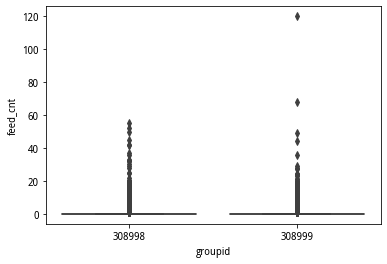

In [51]:
# # Visualization --箱线图
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["feed_cnt"])

<AxesSubplot:xlabel='groupid', ylabel='post_cnt'>

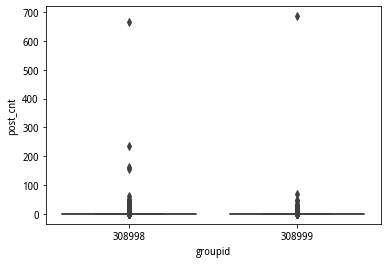

In [52]:
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["post_cnt"])

<AxesSubplot:xlabel='groupid', ylabel='feed_cnt_hot_100'>

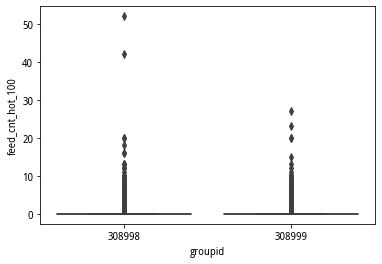

In [55]:
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["feed_cnt_hot_100"])

<AxesSubplot:xlabel='groupid', ylabel='feed_cnt_hot_5k'>

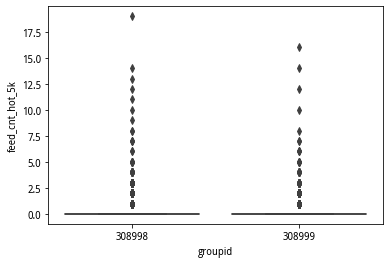

In [56]:
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["feed_cnt_hot_5k"])